In [1]:
import csv
import os
import json
import itertools
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats, special
import matplotlib.pyplot as plt

CWD = os.path.abspath("")  # get jupyter notebook path
path_ = os.path.join(CWD, "batch")

In [2]:
def transform_rating(ratings):
    avg = np.mean(ratings)
    if avg <= -2 / 5:
        return -1
    elif avg >= 2 / 5:
        return 1
    return 0


def pval_star(pval, star=True):
    if star:
        return "" + "*" * (pval < 0.05) + "*" * (pval < 0.01) + "*" * (pval < 0.001) + "*" * (pval < 0.0001)
    else:
        if pval >= 0.05:
            return "p≥0.05"
        elif 0.01 <= pval < 0.05:
            return "p<0.05"
        elif 0.001 <= pval < 0.01:
            return "p<0.01"
        elif 0.0001 <= pval < 0.001:
            return "p<0.001"
        else:
            return "p<0.0001"

In [3]:
ratings = []
sreader = None

n_train = 0
for str_ in ["rated_training_more_neg.csv", "rated_validation_more_neg.csv"]:
    with open(os.path.join(path_, str_), newline="\n", encoding="utf8") as csvfile:
        sreader = csv.reader(csvfile, delimiter=",", quotechar='"')
        next(sreader)
        for row in sreader:
            n_rater = len(row) - 1
            try:
                ratings.append([float(val) for val in row[1 : n_rater + 1]])
            except:
                print(row)
            if str_ == "rated_training_more_neg.csv":
                n_train += 1

ratings = np.array(ratings).T
averaged = np.array([transform_rating(v) for v in np.mean(ratings, 0)])

n1, n2, n3 = special.comb(ratings.shape[0], 2, exact=True), ratings.shape[0], ratings.shape[0]
nn = n1 + n2 + n3
samples = [[None for _ in range(n1)], [None for _ in range(n2)], [None for _ in range(n3)]]

In [ ]:
ratings_machine = np.zeros((2, ratings.shape[1]), dtype=int)

fname_M_1106 = "batch_SERIALNUMBER1_output.jsonl"
fname_M_1106T = "batch_SERIALNUMBER2_output.jsonl"
badrates = np.zeros((2, 3), dtype=int)  # training, validation, both
n_train

for m, fname in enumerate([fname_M_1106, fname_M_1106T]):
    print(f"model {m}")
    with open(os.path.join(path_, fname)) as f:
        for q, l in enumerate(f):
            jsonD = json.loads(l)
            model_str = jsonD["response"]["body"]["model"]

            ans = jsonD["response"]["body"]["choices"]
            if len(ans) != 1:
                raise Exception("bruh")
            rate = ans[0]["message"]["content"].strip().replace("+1", "1")
            try:
                ratings_machine[m, q] = int(rate)
            except:
                print(rate)
                ratings_machine[m, q] = 0
                if q < n_train:
                    badrates[m, 0] += 1
                else:
                    badrates[m, 1] += 1
                badrates[m, 2] += 1
        print(model_str)

print(badrates)
print(n_train, ratings.shape[1] - n_train, ratings.shape[1])

In [9]:
col_mask = slice(n_train, ratings.shape[1])  # validation

for idx, (idx1, idx2) in enumerate(itertools.combinations(range(ratings.shape[0]), 2)):
    spear = stats.spearmanr(ratings[idx1, col_mask], ratings[idx2, col_mask])
    r1, p1 = spear.correlation, spear.pvalue
    samples[0][idx] = r1

for idx in range(ratings.shape[0]):
    spear = stats.spearmanr(ratings[idx, col_mask], ratings_machine[0, col_mask])
    r1, p1 = spear.correlation, spear.pvalue
    samples[1][idx] = r1

    spear = stats.spearmanr(ratings[idx, col_mask], ratings_machine[1, col_mask])
    r1, p1 = spear.correlation, spear.pvalue
    samples[2][idx] = r1


a = np.mean(samples[0])  # Human average agreement.
b = np.mean(samples[2])  # Trained model agreement.
print(f"{a:.4f} {b:.4f} {(b-a)/a*100:.2f}%")

0.3960 0.5083 28.37%


(0, 1) t=1.572, p=0.1552730431476898 (), df=7.847337535311261
(0, 2) t=-1.646, p=0.1467356407240832 (), df=6.54471093823924
(1, 2) t=-2.660, p=0.029929086294574244 (*), df=7.664503044209763


/var/folders/fy/v31sdshs3bb619z7wtc8pdv00000gr/T/ipykernel_98746/946982075.py:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return "" + "*" * (pval < 0.05) + "*" * (pval < 0.01) + "*" * (pval < 0.001) + "*" * (pval < 0.0001)


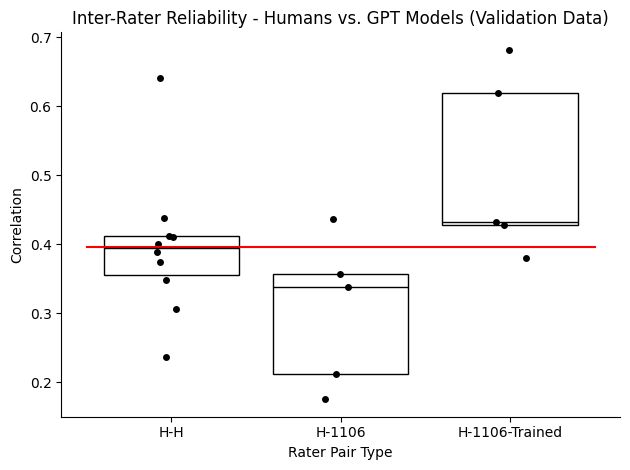

In [10]:
col_mask = slice(n_train, ratings.shape[1])
samples = [[None for _ in range(n1)], [None for _ in range(n2)], [None for _ in range(n3)]]

df_fdpc = pd.DataFrame(data={x: [None for _ in range(nn)] for x in ["Correlation", "Rater Pair Type"]})
for idx, (idx1, idx2) in enumerate(itertools.combinations(range(ratings.shape[0]), 2)):
    spear = stats.spearmanr(ratings[idx1, col_mask], ratings[idx2, col_mask])
    r1, p1 = spear.correlation, spear.pvalue
    df_fdpc.at[idx, "Correlation"] = r1
    df_fdpc.at[idx, "Rater Pair Type"] = "H-H"
    samples[0][idx] = r1

for idx in range(ratings.shape[0]):
    spear = stats.spearmanr(ratings[idx, col_mask], ratings_machine[0, col_mask])
    r1, p1 = spear.correlation, spear.pvalue
    df_fdpc.at[idx + n1, "Correlation"] = r1
    df_fdpc.at[idx + n1, "Rater Pair Type"] = "H-1106"
    samples[1][idx] = r1

    spear = stats.spearmanr(ratings[idx, col_mask], ratings_machine[1, col_mask])
    r1, p1 = spear.correlation, spear.pvalue
    df_fdpc.at[idx + n1 + n2, "Correlation"] = r1
    df_fdpc.at[idx + n1 + n2, "Rater Pair Type"] = "H-1106-Trained"
    samples[2][idx] = r1


ttest_res = dict()
for idx, (s1, s2) in enumerate(itertools.combinations(range(len(samples)), 2)):
    res = stats.ttest_ind(samples[s1], samples[s2], equal_var=False, alternative="two-sided")
    ttest_res[(s1, s2)] = res
    print(f"{(s1, s2)} t={res.statistic:.3f}, p={res.pvalue} ({pval_star(res.pvalue, star=True)}), df={res.df}")

fig, ax = plt.subplots()
kwargs = dict(
    boxprops={"facecolor": "none", "edgecolor": "black"},
    # meanprops={"marker": "_", "markerfacecolor": "black", "markeredgecolor": "black", "markersize": 12},
    medianprops={"color": "black"},
    whiskerprops={"visible": False},
    showmeans=False,
    showfliers=False,
    showbox=True,
    showcaps=False,
    legend=False,
)
sns.boxplot(data=df_fdpc, x="Rater Pair Type", y="Correlation", ax=ax, zorder=2, **kwargs)
sns.stripplot(data=df_fdpc, x="Rater Pair Type", y="Correlation", jitter=True, color="black", alpha=1, ax=ax, zorder=0)
sns.despine()

ax.plot(ax.get_xlim(), [np.mean(samples[0]), np.mean(samples[0])], color="red")

strin = "Validation"
fname = f"Inter-Rater Reliability - Humans vs. GPT Models ({strin} Data)"
ax.set_title(fname)

fig.tight_layout()
plt.show()

# bbox_inches="tight": auto resize fig to fit titles and such
fig.savefig(os.path.join(CWD, "output", f"SUPP {fname}.svg"), bbox_inches="tight", transparent=True)
fig.clf()  # clear figure
plt.close(fig=fig)  # close figure